In [1]:
# display plots inline
%matplotlib notebook

# imports
import os
import numpy as np
import pandas as pd
import pymc3 as pm
from bambi import Model, Prior
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pymc3_utils as pmu

# suppress system warnings for legibility
import warnings
warnings.filterwarnings('ignore')

# resize plots to fit labels inside bounding box
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# MPI color scheme
sns.set(style='white', palette='Set2')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Cambridge Recognition Memory Tasks
## Loading participant-level predictors

In [2]:
df_reading = pd.read_csv('data/reading_intercepts.tsv', sep='\t')[['pp', 'ravens_intercept', 'span_intercept', 'raw_reading_score', 'adjusted_reading_score']]
display(df_reading.head().round(2))

,pp,ravens_intercept,span_intercept,raw_reading_score,adjusted_reading_score
0,low_1,0.32,0.51,12.5,-0.83
1,low_10,-0.13,0.00,45.5,2.06
2,low_11,0.16,0.49,32.5,0.64
3,low_12,0.40,0.29,22.5,0.20
4,low_13,-0.50,0.70,23.5,0.31


## Loading object memory data

In [3]:
# start by loading the data
df_comt = pd.read_csv('data/cambridge.tsv', sep='\t').dropna()
df_comt = df_comt.merge(df_reading, left_on='pp', right_on='pp').dropna()
display(df_comt.head().round(2))

,Unnamed: 0,trialNo,RT,ACC,literate,number,visual_noise,learn_trial,category,item,trial,pp,subject,ravens_intercept,span_intercept,raw_reading_score,adjusted_reading_score
0,11,1.0,3.22,1.0,low,1,no_noise,learn,bikes,bikes_1.0,0,low_1,1,0.32,0.51,12.5,-0.83
1,12,2.0,11.06,1.0,low,1,no_noise,learn,bikes,bikes_2.0,1,low_1,1,0.32,0.51,12.5,-0.83
2,13,3.0,4.83,1.0,low,1,no_noise,learn,bikes,bikes_3.0,2,low_1,1,0.32,0.51,12.5,-0.83
3,18,4.0,7.58,0.0,low,1,no_noise,learn,bikes,bikes_4.0,3,low_1,1,0.32,0.51,12.5,-0.83
4,19,5.0,4.34,1.0,low,1,no_noise,learn,bikes,bikes_5.0,4,low_1,1,0.32,0.51,12.5,-0.83


## Dummy coding, scaling, centering

In [4]:
# standardize reading scores
df_comt['raw_reading_score'] = pmu.standardize(df_comt['raw_reading_score'])
df_comt['adjusted_reading_score'] = pmu.standardize(df_comt['adjusted_reading_score'])
df_comt['ravens_intercept'] = pmu.standardize(df_comt['ravens_intercept'])
df_comt['span_intercept'] = pmu.standardize(df_comt['span_intercept'])

# create dummies for cars and faces, bikes will be the default
df_comt['cars'] = pd.get_dummies(df_comt['category'])['cars']
df_comt['faces'] = pd.get_dummies(df_comt['category'])['faces']
df_comt['bikes'] = pd.get_dummies(df_comt['category'])['bikes']

# create dummy for visual noise, no noise will be the default
df_comt['noise'] = pd.get_dummies(df_comt['visual_noise'])['noise']

# create dummy for learn trials, not learn will be the default
df_comt['learn'] = pd.get_dummies(df_comt['learn_trial'])['learn']

# dump learning trials
df_comt = df_comt[df_comt['learn'] == 0]

display(df_comt.head().round(2))

,Unnamed: 0,trialNo,RT,ACC,literate,number,visual_noise,learn_trial,category,item,...,subject,ravens_intercept,span_intercept,raw_reading_score,adjusted_reading_score,cars,faces,bikes,noise,learn
18,51,19.0,6.92,1.0,low,1,no_noise,no_learn,bikes,bikes_19.0,...,1,0.43,0.87,-0.61,-0.47,0,0,1,0,0
19,52,46.0,5.51,1.0,low,1,no_noise,no_learn,bikes,bikes_46.0,...,1,0.43,0.87,-0.61,-0.47,0,0,1,0,0
20,53,36.0,3.03,1.0,low,1,no_noise,no_learn,bikes,bikes_36.0,...,1,0.43,0.87,-0.61,-0.47,0,0,1,0,0
21,54,31.0,3.28,0.0,low,1,no_noise,no_learn,bikes,bikes_31.0,...,1,0.43,0.87,-0.61,-0.47,0,0,1,0,0
22,55,30.0,3.56,1.0,low,1,no_noise,no_learn,bikes,bikes_30.0,...,1,0.43,0.87,-0.61,-0.47,0,0,1,0,0


## Modeling

In [5]:
# default model params
defaults = {
    'samples': 5000,
    'tune': 2500,
    'chains': 4,
    'init': 'advi+adapt_diag',
    'family': 'bernoulli',
    'priors': {'fixed': 'narrow', 'random': 'narrow'},
}
# these models take a while to sample, so we'll store them in a model pickler in case we want to reuse them later
# the pickled models and traces are too big to include in the git repository
# so if you're reproducing this analysis you'll have to do the sampling yourself
pickler = pmu.ModelPickler('object_recognition_models.pkl')

In [58]:
model0 = Model(df_comt)
model0.fit('ACC ~ noise*cars + noise*faces',
                           **defaults)
pickler.add(model0, 'noise * category')

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 10,685:  28%|██▊       | 14095/50000 [00:45<01:57, 306.72it/s]
Convergence achieved at 14100
Interrupted at 14,099 [28%]: Average Loss = 11,190
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise:faces, faces, noise:cars, cars, noise, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [04:03<00:00, 30.01draws/s] 


In [10]:
model1 = Model(df_comt)
model1.fit('ACC ~ noise*cars + noise*faces + raw_reading_score',
                           **defaults)
pickler.add(model1, 'noise * category + unadj_reading')

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 10,597:  41%|████▏     | 20675/50000 [01:05<01:32, 316.84it/s]
Convergence achieved at 20700
Interrupted at 20,699 [41%]: Average Loss = 11,082
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_reading_score, noise:faces, faces, noise:cars, cars, noise, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [04:37<00:00, 108.09draws/s]


In [69]:
model2 = Model(df_comt)
model2.fit('ACC ~ noise*cars + noise*faces + noise*raw_reading_score',
                           **defaults)
pickler.add(model2, 'noise * category + noise * unadj_reading')

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 10,599:  43%|████▎     | 21384/50000 [01:28<01:58, 242.37it/s]
Convergence achieved at 21400
Interrupted at 21,399 [42%]: Average Loss = 11,111
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise:raw_reading_score, raw_reading_score, noise:faces, faces, noise:cars, cars, noise, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [06:12<00:00, 80.64draws/s] 


In [62]:
model3 = Model(df_comt)
model3.fit('ACC ~ noise*cars + noise*faces + cars*raw_reading_score + faces*raw_reading_score',
                           **defaults)
pickler.add(model3, 'noise * category + category * unadj_reading')

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 10,604:  42%|████▏     | 20986/50000 [01:14<01:43, 280.07it/s]
Convergence achieved at 21000
Interrupted at 20,999 [41%]: Average Loss = 11,158
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [faces:raw_reading_score, cars:raw_reading_score, raw_reading_score, noise:faces, faces, noise:cars, cars, noise, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [05:50<00:00, 24.34draws/s] 


In [63]:
model4 = Model(df_comt)
model4.fit('ACC ~ noise*cars*raw_reading_score + noise*faces*raw_reading_score',
                           **defaults)
pickler.add(model4, 'noise * category * unadj_reading')

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 10,612:  45%|████▌     | 22691/50000 [01:34<01:53, 239.70it/s]
Convergence achieved at 22700
Interrupted at 22,699 [45%]: Average Loss = 11,220
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise:faces:raw_reading_score, faces:raw_reading_score, noise:faces, faces, noise:cars:raw_reading_score, cars:raw_reading_score, noise:raw_reading_score, raw_reading_score, noise:cars, cars, noise, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [09:03<00:00, 55.25draws/s]


## Model comparison (task by participant random slope models)

<IPython.core.display.Javascript object>


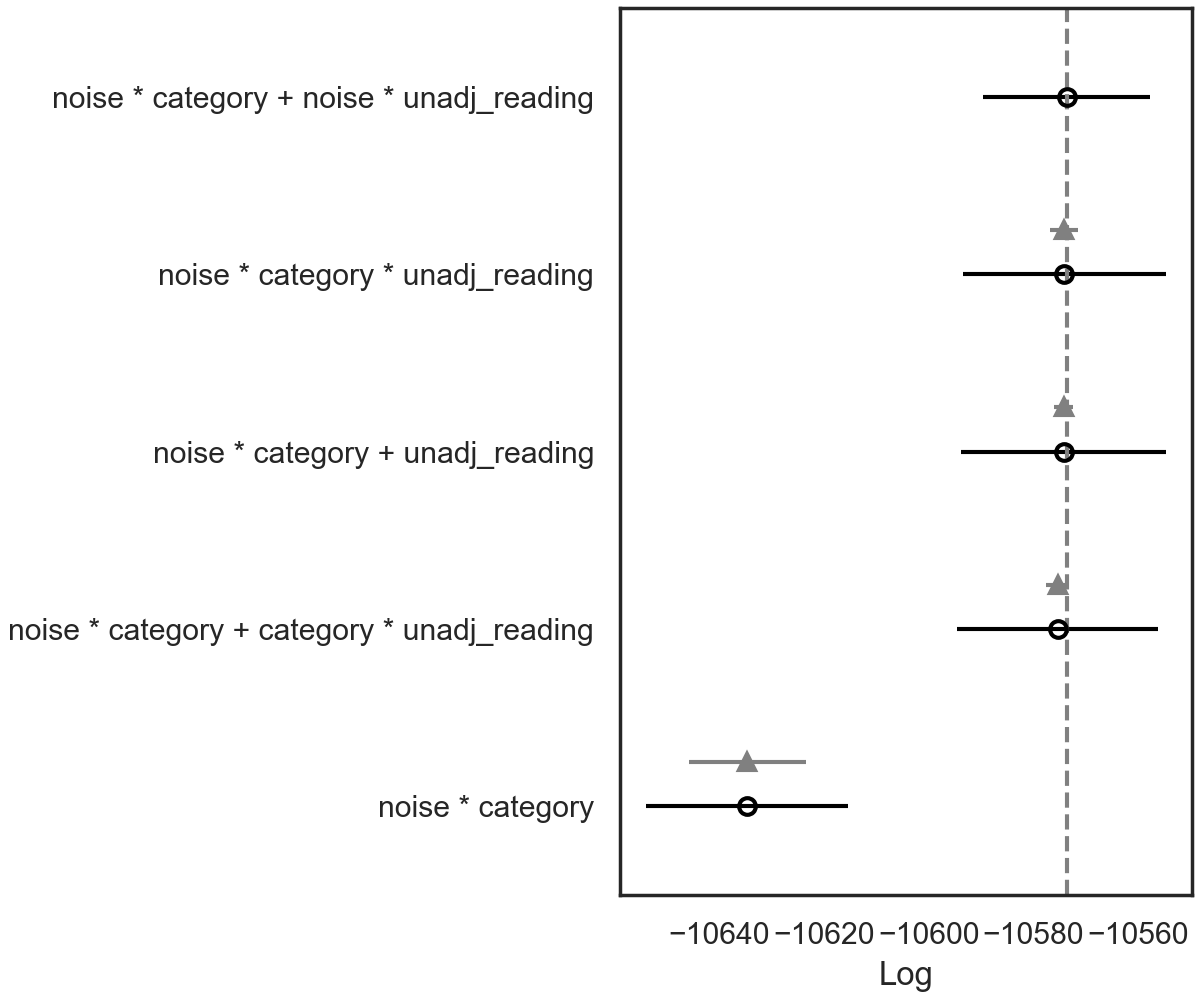

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
noise * category + noise * unadj_reading,0,-10573.6,8.00913,0,0.330916,15.8875,0,False,log
noise * category * unadj_reading,1,-10574.1,12.0514,0.428936,0.334744,19.3707,2.6967,False,log
noise * category + unadj_reading,2,-10574.2,7.05006,0.584786,0.240324,19.5417,1.76108,False,log
noise * category + category * unadj_reading,3,-10575.3,8.97192,1.70328,0.0940157,19.2503,2.1782,False,log
noise * category,4,-10634.7,6.01286,61.0517,3.80577e-16,19.2882,11.1932,False,log


In [70]:
reload(pmu)
g_comparison, comparison = pmu.compare(pickler.models, ic='LOO')
plt.savefig('figures/object_recognition_model_comparison.pdf')
plt.savefig('figures/object_recognition_model_comparison.png', dpi=600, bbox_inches='tight')
display(comparison)

Since we are looking for the best parsimonious model for the effect of literacy on recognition memory, rather looking for the most accurate predictive model (which we could get by model averaging), we are ignoring the weights column and instead selecting the single best-fit model.  
The four best models in our model comparison are all within the standard error of the best-fit model, indicating highly similar model fit. In the absence of a decisive best-fit model, we pick the most parsimonious (least complex) model from this top four. This is the model corresponding with formula `ACC ~ noise * category + reading`, for which we will also fit a parallel model with uncorrected reading score for visual comparison purposes.

In [6]:
model1_adj = Model(df_comt)
model1_adj.fit('ACC ~ noise*cars + noise*faces + adjusted_reading_score',
                           **defaults)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 10,654:  42%|████▏     | 20888/50000 [01:11<01:40, 290.15it/s]
Convergence achieved at 20900
Interrupted at 20,899 [41%]: Average Loss = 11,136
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [adjusted_reading_score, noise:faces, faces, noise:cars, cars, noise, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [05:30<00:00, 90.78draws/s] 


<IPython.core.display.Javascript object>


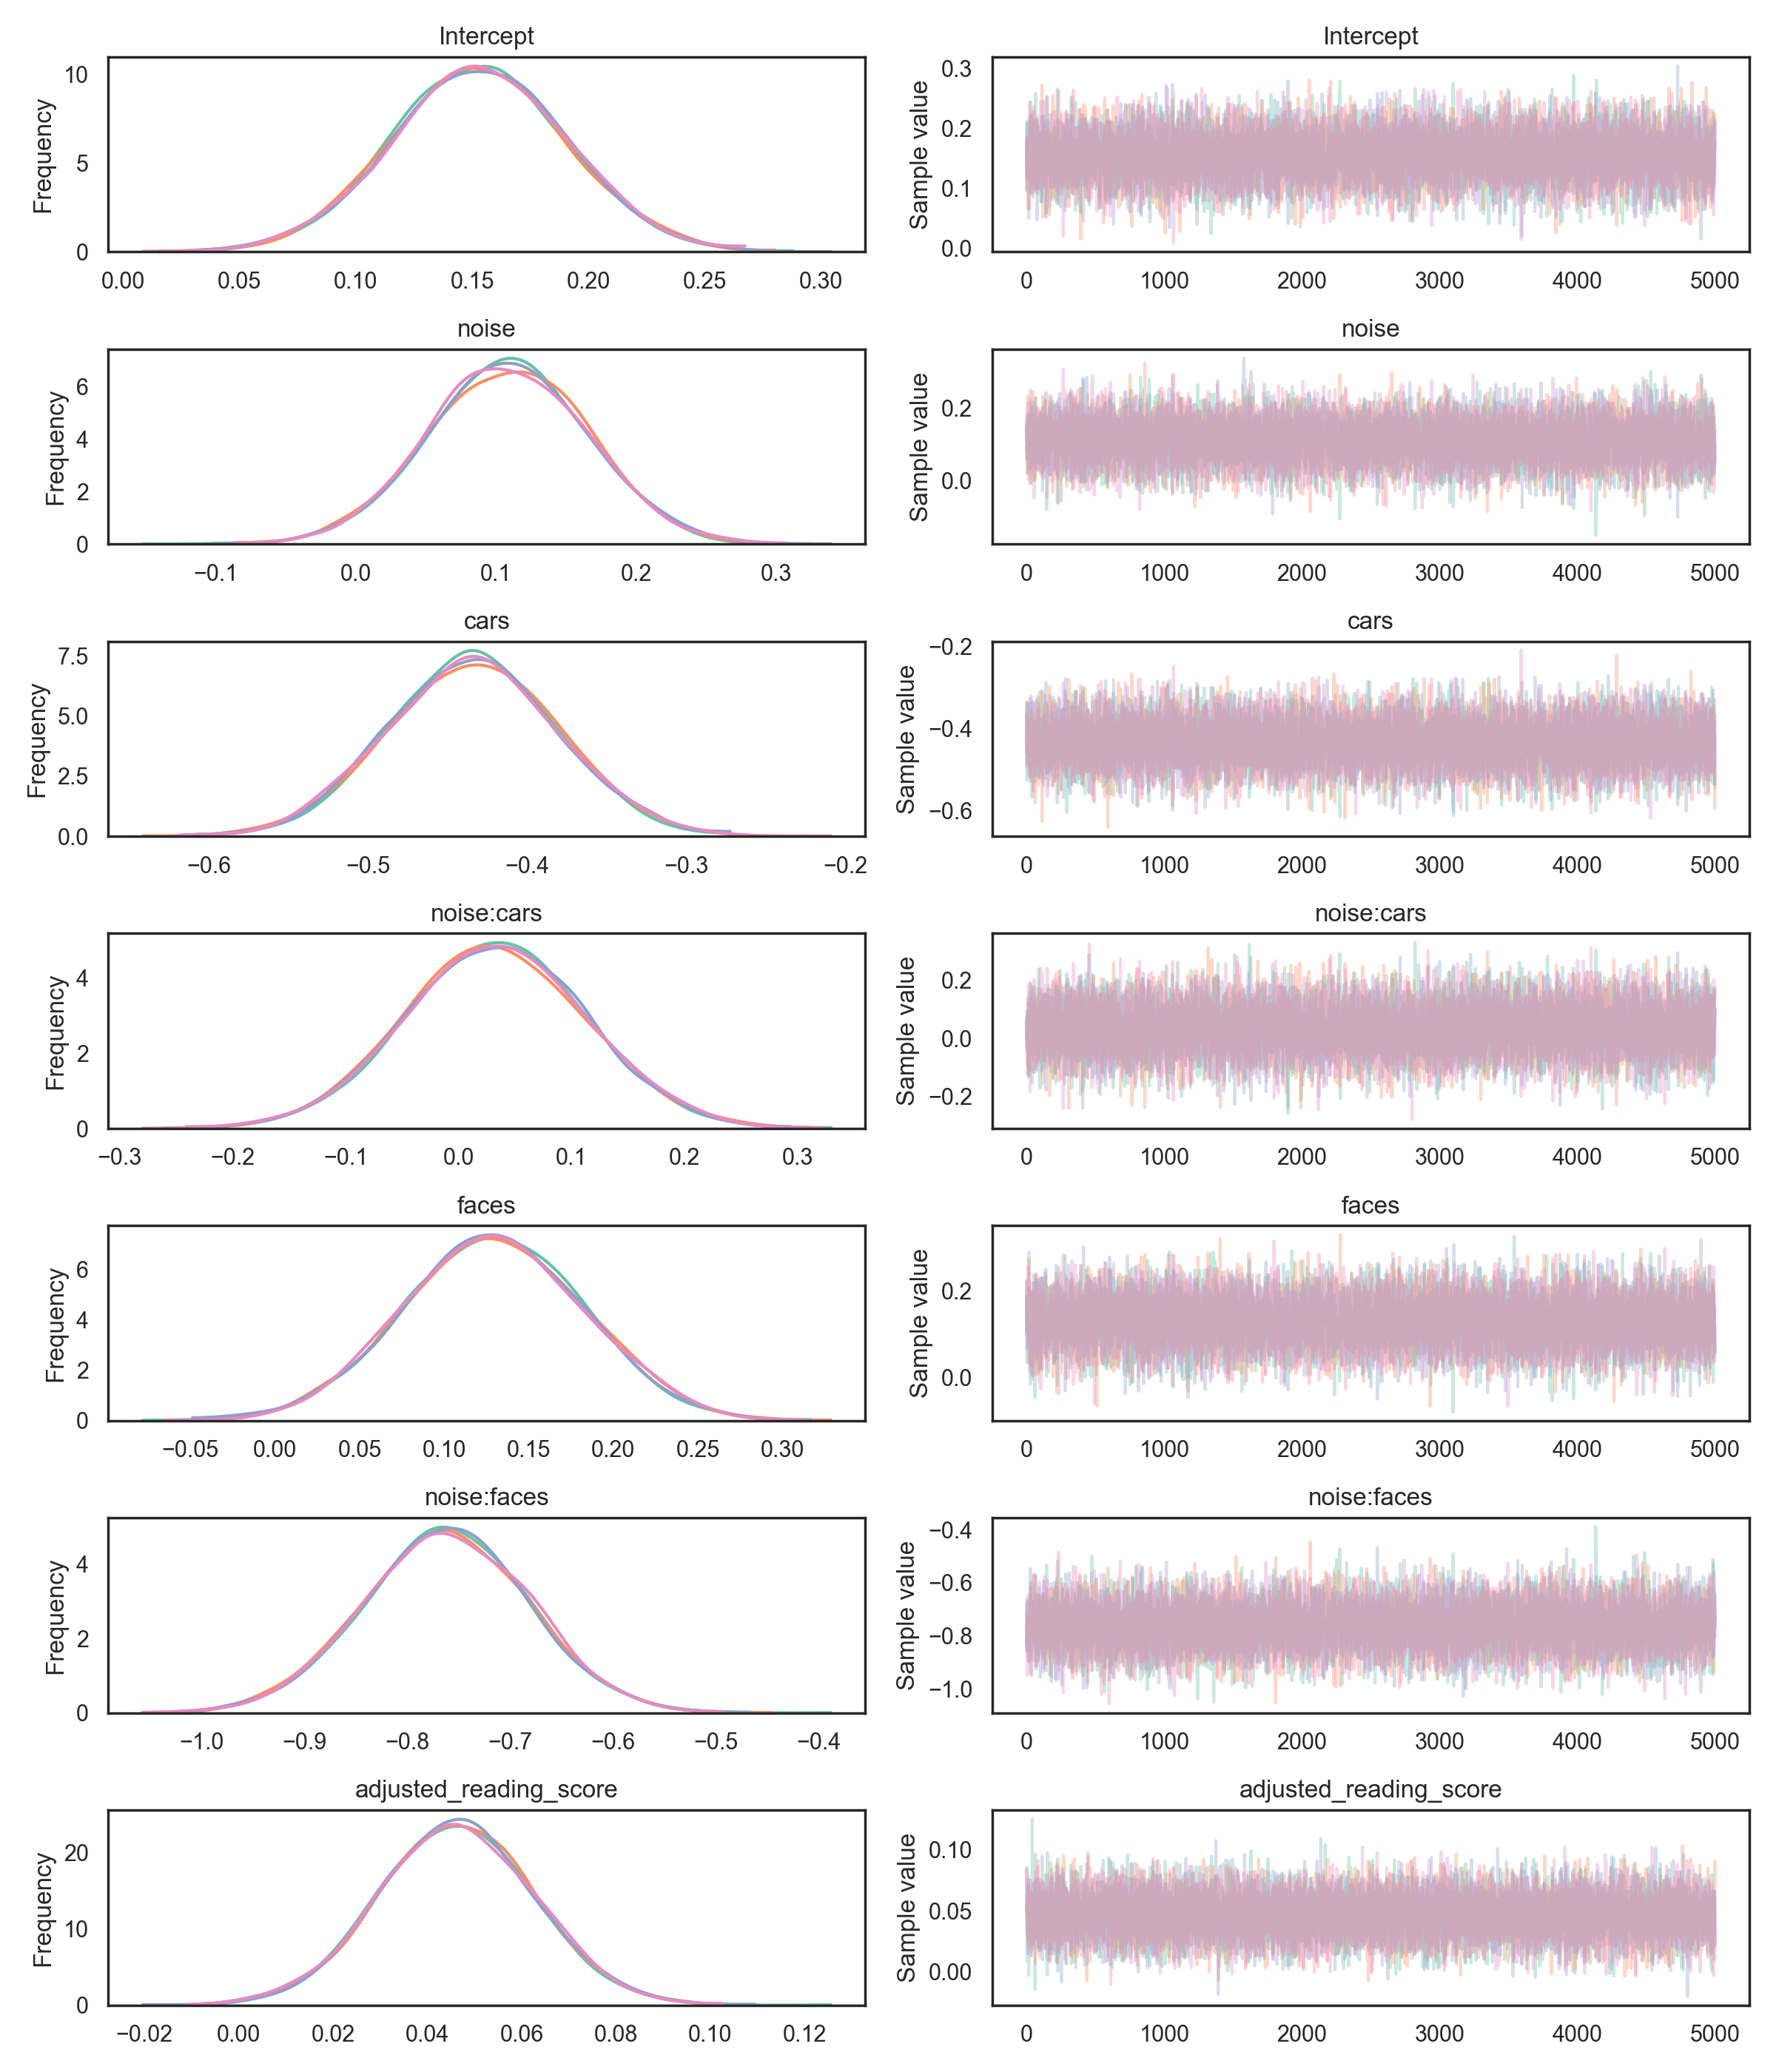

In [34]:
g_traces = pm.traceplot(model1_adj.backend.trace)
plt.savefig('figures/object_recognition_model_traces.png', dpi=600)

<IPython.core.display.Javascript object>


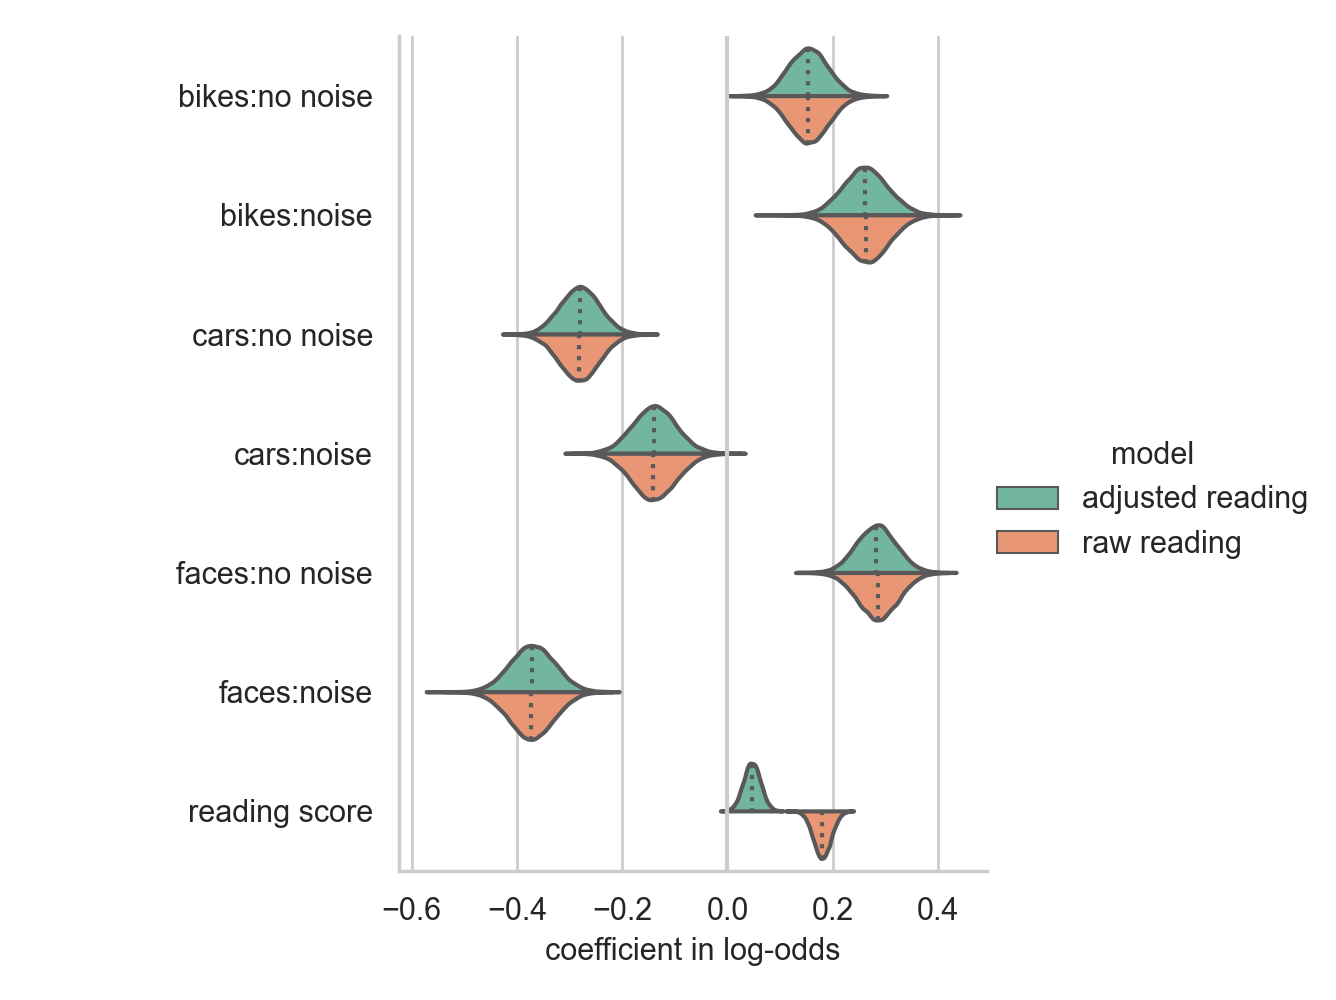

In [67]:
sns.set(style='whitegrid', palette='Set2', rc={'axes.labelsize': 11})

# create split-violin plot of posterior densities
trace = model1_adj.backend.trace
effects = pmu.conditional_effects(trace, simple_effects=['noise', 'faces', 'cars'], interactions=['adjusted_reading_score'])
renamed_effects = pmu.rename_vars(effects, varnames_dict={
    'Intercept': 'bikes:no noise',
    'noise': 'bikes:noise',
    'cars': 'cars:no noise',
    'faces': 'faces:no noise',
    'noise:cars': 'cars:noise',
    'noise:faces': 'faces:noise',
    'adjusted_reading_score': 'adjusted reading score',
})

trace_raw = model1.backend.trace
effects_raw = pmu.conditional_effects(trace_raw, simple_effects=['noise', 'faces', 'cars'], interactions=['raw_reading_score'])
renamed_effects_raw = pmu.rename_vars(effects_raw, varnames_dict={
    'Intercept': 'bikes:no noise',
    'noise': 'bikes:noise',
    'cars': 'cars:no noise',
    'faces': 'faces:no noise',
    'noise:cars': 'cars:noise',
    'noise:faces': 'faces:noise',
    'raw_reading_score': 'raw reading score',
})

df1 = pmu.trace_to_df(renamed_effects)
df1['model'] = 'adjusted reading'

df2 = pmu.trace_to_df(renamed_effects_raw)
df2['model'] = 'raw reading'

df_traces = pd.concat([df1, df2])
df_traces['variable'] = df_traces['variable'].str.replace('adjusted reading score', 'reading score').replace('raw reading score', 'reading score')

rcParams.update({'figure.autolayout': False})
g = sns.catplot(kind='violin', data=df_traces,
                y='variable', x='value', hue='model',
                split=True, cut=0,
                inner='quartile',
                order=sorted(df_traces['variable'].unique()))
g.set(xlabel='coefficient in log-odds', ylabel='')
g._legend.set_title('model', prop={'size': 11})
for l in g.ax.lines[0::3]:
    l.set_alpha(0)
for l in g.ax.lines[1::3]:
    l.set_linestyle(':')
for l in g.ax.lines[2::3]:
    l.set_alpha(0)
g.axes[0][0].axvline(0, color='.8', linestyle='-')
plt.savefig('figures/split_violins.pdf')
plt.savefig('figures/split_violins.png', dpi=600, bbox_inches='tight')

In [68]:
# display unadjusted effects table
display(pm.summary(renamed_effects_raw, credible_interval=.95).round(2))

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bikes:no noise,0.15,0.04,0.08,0.23,0.0,0.0,7326.0,7326.0,7327.0,10172.0,1.0
bikes:noise,0.26,0.04,0.18,0.35,0.0,0.0,15104.0,14900.0,15106.0,14173.0,1.0
cars:no noise,-0.28,0.04,-0.36,-0.21,0.0,0.0,19760.0,19716.0,19768.0,16124.0,1.0
faces:no noise,0.29,0.04,0.21,0.36,0.0,0.0,21414.0,21342.0,21419.0,16877.0,1.0
cars:noise,-0.14,0.04,-0.22,-0.06,0.0,0.0,22466.0,22466.0,22484.0,18679.0,1.0
faces:noise,-0.37,0.04,-0.46,-0.29,0.0,0.0,22885.0,22529.0,22948.0,18623.0,1.0
raw reading score,0.18,0.02,0.15,0.21,0.0,0.0,17515.0,17440.0,17506.0,14214.0,1.0


In [69]:
# display adjusted effects table
display(pm.summary(renamed_effects, credible_interval=.95).round(2))

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bikes:no noise,0.15,0.04,0.08,0.23,0.0,0.0,6738.0,6738.0,6734.0,9919.0,1.0
bikes:noise,0.26,0.04,0.18,0.35,0.0,0.0,13939.0,13567.0,13987.0,13655.0,1.0
cars:no noise,-0.28,0.04,-0.35,-0.21,0.0,0.0,17834.0,17834.0,17837.0,14836.0,1.0
faces:no noise,0.28,0.04,0.21,0.36,0.0,0.0,21118.0,20950.0,21122.0,17074.0,1.0
cars:noise,-0.14,0.04,-0.22,-0.06,0.0,0.0,21900.0,21557.0,21873.0,18754.0,1.0
faces:noise,-0.37,0.04,-0.45,-0.29,0.0,0.0,22858.0,22858.0,22864.0,18267.0,1.0
adjusted reading score,0.05,0.02,0.01,0.08,0.0,0.0,17959.0,17275.0,17953.0,14074.0,1.0


<IPython.core.display.Javascript object>


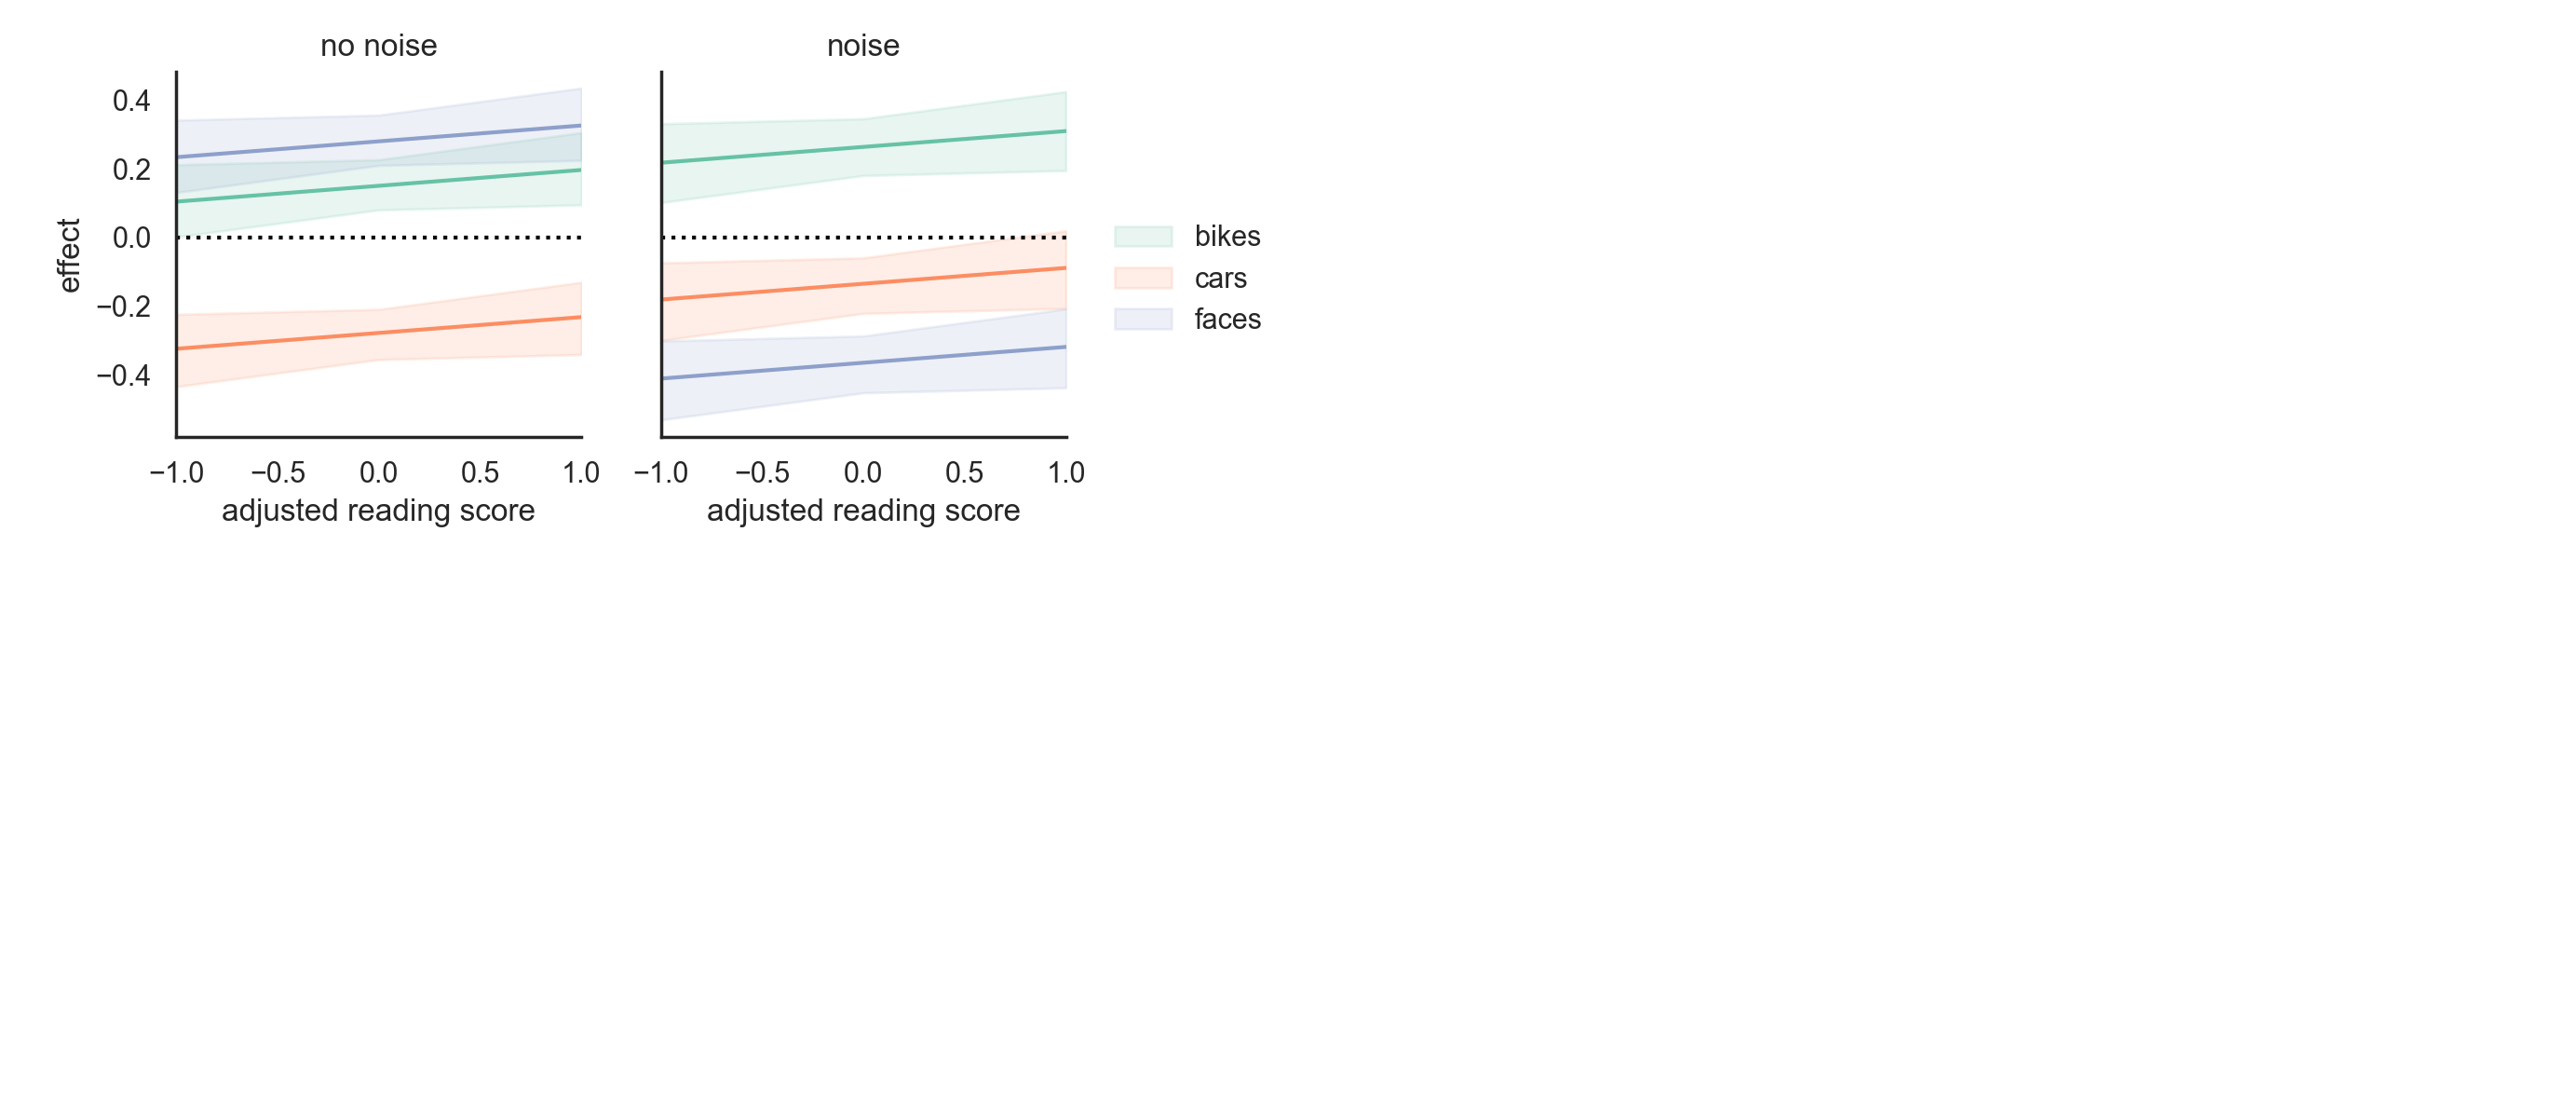

In [45]:
from importlib import reload
reload(pmu)
g_effects = pmu.plot_effects(renamed_effects,
                             cols=['no noise', 'noise'],
                             hues=['bikes', 'cars', 'faces'],
                             main='adjusted reading score')
plt.savefig('figures/effects.pdf')
plt.savefig('figures/effects.png', dpi=600, bbox_inches='tight')

There are some differences visible between the noise and no noise conditions for the different conditions. Computing the differences in the posterior estimates for these conditions will give us an idea of how robust the differences are.

In [26]:
renamed_effects.add_values({
    'bikes:noise - bikes:no noise': renamed_effects['bikes:noise'] - renamed_effects['bikes:no noise'],
    'cars:noise - cars:no noise': renamed_effects['cars:noise'] - renamed_effects['cars:no noise'],
    'faces:noise - faces:no noise': renamed_effects['faces:noise'] - renamed_effects['faces:no noise'],
})
display(pm.summary(renamed_effects, credible_interval=.95).round(2))

,mean,sd,mc_error,hpd_2.5,hpd_97.5,mode,n_eff,Rhat
bikes:no noise,0.15,0.04,0.0,0.08,0.23,0.15,8194.79,1.0
bikes:noise,0.26,0.04,0.0,0.18,0.35,0.26,18618.57,1.0
cars:no noise,-0.28,0.04,0.0,-0.36,-0.21,-0.28,21017.51,1.0
faces:no noise,0.28,0.04,0.0,0.21,0.36,0.28,22639.29,1.0
cars:noise,-0.14,0.04,0.0,-0.22,-0.06,-0.13,22645.20,1.0
faces:noise,-0.37,0.04,0.0,-0.45,-0.29,-0.37,21203.31,1.0
adjusted reading score,0.05,0.02,0.0,0.01,0.08,0.05,17770.86,1.0
bikes:noise - bikes:no noise,0.11,0.06,0.0,-0.00,0.22,0.11,8569.73,1.0
cars:noise - cars:no noise,0.14,0.06,0.0,0.03,0.25,0.13,20515.24,1.0
faces:noise - faces:no noise,-0.65,0.06,0.0,-0.76,-0.54,-0.65,21618.39,1.0


One last thing to check is whether including each participants' ravens and span intercepts as predictors in the model affects our estimate for the effect of adjusted reading score. (We're not really expecting this, because we've taken care to make sure the span and ravens intercepts have no shared variance with the adjusted reading score.)

In [18]:
model1_full = Model(df_comt)
model1_full.fit('ACC ~ noise*cars + noise*faces + adjusted_reading_score + ravens_intercept + span_intercept',
                           **defaults)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 10,558:  43%|████▎     | 21371/50000 [01:14<01:39, 286.84it/s]
Convergence achieved at 21400
Interrupted at 21,399 [42%]: Average Loss = 11,232
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [span_intercept, ravens_intercept, adjusted_reading_score, noise:faces, faces, noise:cars, cars, noise, Intercept]
Sampling 4 chains: 100%|██████████| 30000/30000 [05:28<00:00, 91.36draws/s] 


<IPython.core.display.Javascript object>


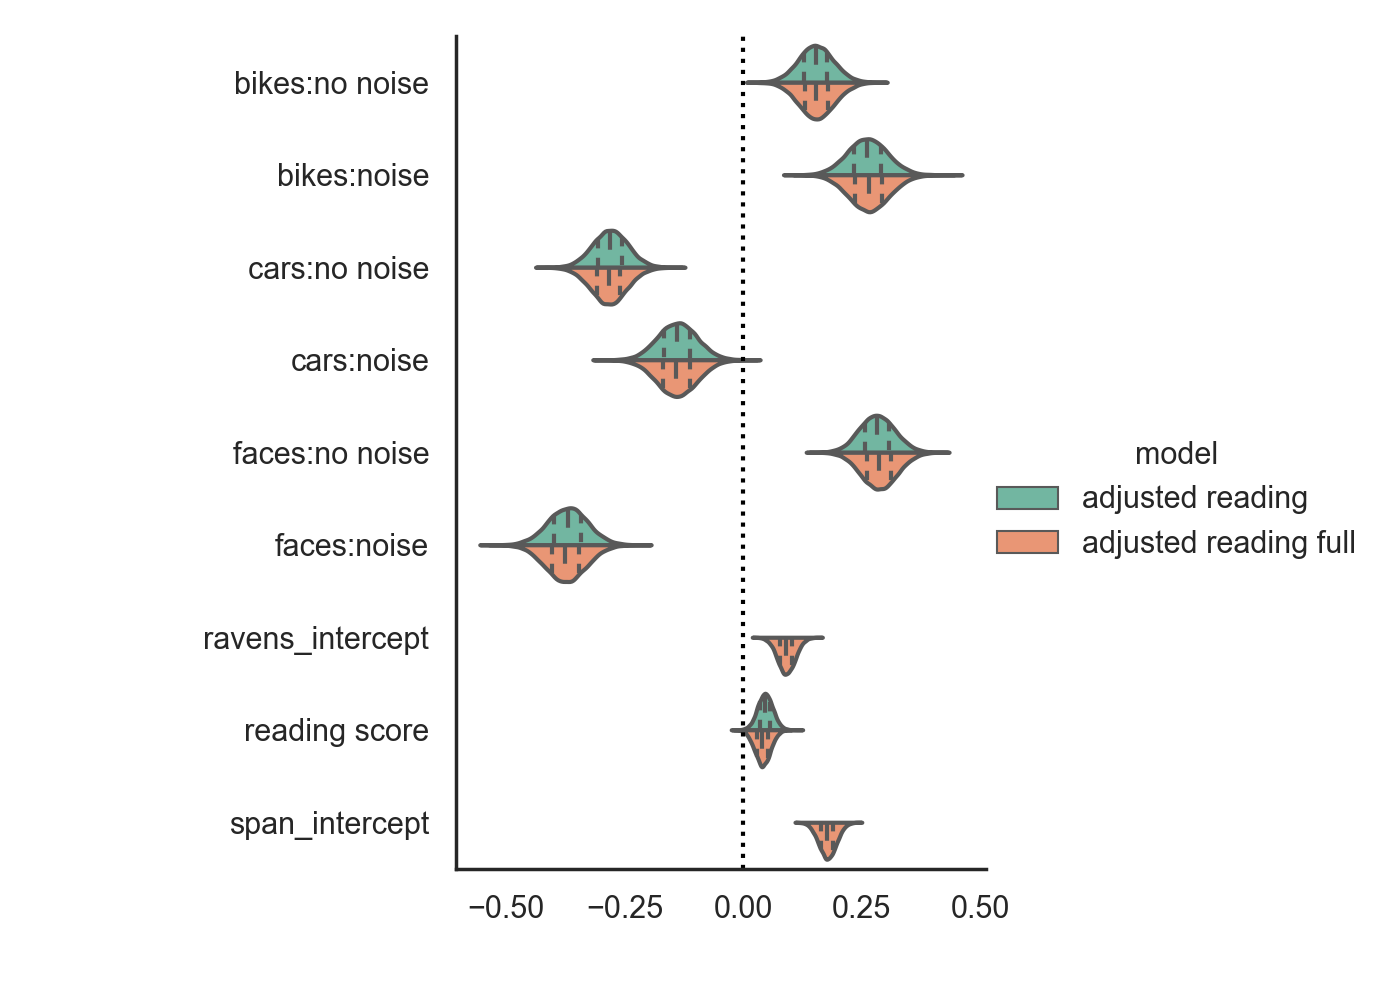

In [40]:
# create split-violin plot of posterior densities
trace_full = model1_full.backend.trace
effects_full = pmu.conditional_effects(trace_full, simple_effects=['noise', 'faces', 'cars'], interactions=['adjusted_reading_score', 'ravens_intercept', 'span_intercept'])
renamed_effects_full = pmu.rename_vars(effects_full, varnames_dict={
    'Intercept': 'bikes:no noise',
    'noise': 'bikes:noise',
    'cars': 'cars:no noise',
    'faces': 'faces:no noise',
    'noise:cars': 'cars:noise',
    'noise:faces': 'faces:noise',
    'adjusted_reading_score': 'adjusted reading score',
})

df3 = pmu.trace_to_df(renamed_effects_full)
df3['model'] = 'adjusted reading full'

df_traces = pd.concat([df1, df3])
df_traces['variable'] = df_traces['variable'].str.replace('adjusted reading score', 'reading score').replace('raw reading score', 'reading score')

rcParams.update({'figure.autolayout': False})
g = sns.catplot(kind='violin', data=df_traces,
                y='variable', x='value', hue='model',
                split=True, cut=0, inner='quartile', order=sorted(df_traces['variable'].unique()))
g.set(xlabel='', ylabel='')
g._legend.set_title('model', prop={'size': 11})
g.axes[0][0].axvline(0, color='black', linestyle=':')

In [27]:
display(pm.summary(renamed_effects_full, credible_interval=.95).round(2))

,mean,sd,mc_error,hpd_2.5,hpd_97.5,mode,n_eff,Rhat
ravens_intercept,0.09,0.02,0.0,0.05,0.13,0.09,17943.34,1.0
span_intercept,0.18,0.02,0.0,0.14,0.21,0.18,16431.53,1.0
bikes:no noise,0.15,0.04,0.0,0.08,0.23,0.16,9043.96,1.0
bikes:noise,0.27,0.04,0.0,0.18,0.34,0.27,17872.89,1.0
cars:no noise,-0.28,0.04,0.0,-0.36,-0.21,-0.28,22767.94,1.0
faces:no noise,0.29,0.04,0.0,0.21,0.36,0.28,23838.19,1.0
cars:noise,-0.14,0.04,0.0,-0.23,-0.06,-0.14,23199.02,1.0
faces:noise,-0.38,0.04,0.0,-0.45,-0.29,-0.37,23505.56,1.0
adjusted reading score,0.04,0.02,0.0,0.01,0.07,0.04,18131.97,1.0


As expected, ravens and span are both associated with better recognition memory, but this does not appear to affect our estimate for adjusted reading score.

## Using a different reference level
An anonymous reviewer asked whether it would be possible to find a different estimate for the effect of literacy if a different reference level is used in the statistical analysis. Because of the linear algebra involved in (generalized) linear regression and the contrasts used, this is mathematically impossible, but to exclude the possibility of programming or other errors on our part, we include an empirical demonstration below. This is a replication of the first anaylsis presented in this notebook, but with faces as the reference level, instead of bicycles.

In [7]:
# to answer a question from an anonymous reviewer, we run the model with faces as baseline
model1_adj_faces = Model(df_comt)
model1_adj_faces.fit('ACC ~ noise*cars + noise*bikes + adjusted_reading_score',
                           **defaults)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 10,658:  39%|███▉      | 19475/50000 [00:58<01:32, 330.50it/s]
Convergence achieved at 19500
Interrupted at 19,499 [38%]: Average Loss = 11,185
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [adjusted_reading_score, noise:bikes, bikes, noise:cars, cars, noise, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [04:28<00:00, 31.05draws/s] 


<IPython.core.display.Javascript object>


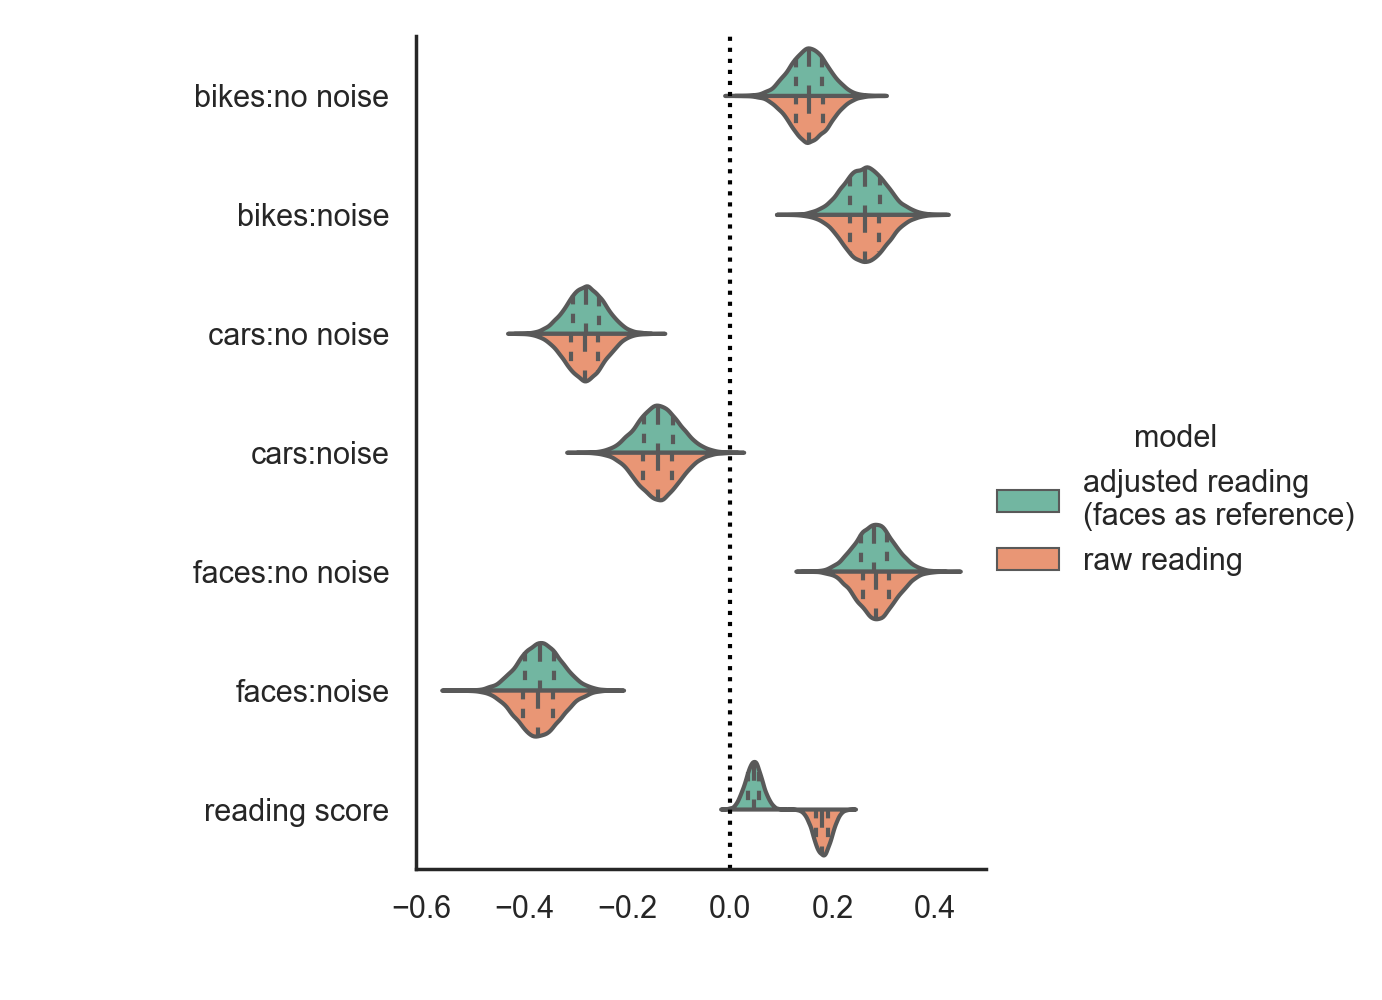

In [36]:
# compute the effects from the faces-as-reference-level model, to answer a question from an anonymous reviewer
trace_faces = model1_adj_faces.backend.trace
effects_faces = pmu.conditional_effects(trace_faces, simple_effects=['noise', 'bikes', 'cars'], interactions=['adjusted_reading_score'])
renamed_effects_faces = pmu.rename_vars(effects_faces, varnames_dict={
    'Intercept': 'faces:no noise',
    'noise': 'faces:noise',
    'cars': 'cars:no noise',
    'bikes': 'bikes:no noise',
    'noise:cars': 'cars:noise',
    'noise:bikes': 'bikes:noise',
    'adjusted_reading_score': 'adjusted reading score',
})

trace_raw = model1.backend.trace
effects_raw = pmu.conditional_effects(trace_raw, simple_effects=['noise', 'faces', 'cars'], interactions=['raw_reading_score'])
renamed_effects_raw = pmu.rename_vars(effects_raw, varnames_dict={
    'Intercept': 'bikes:no noise',
    'noise': 'bikes:noise',
    'cars': 'cars:no noise',
    'faces': 'faces:no noise',
    'noise:cars': 'cars:noise',
    'noise:faces': 'faces:noise',
    'raw_reading_score': 'raw reading score',
})

df1 = pmu.trace_to_df(renamed_effects_faces)
df1['model'] = 'adjusted reading\n(faces as reference)'

df2 = pmu.trace_to_df(renamed_effects_raw)
df2['model'] = 'raw reading'

df_traces = pd.concat([df1, df2])
df_traces['variable'] = df_traces['variable'].str.replace('adjusted reading score', 'reading score').replace('raw reading score', 'reading score')

rcParams.update({'figure.autolayout': False})
g = sns.catplot(kind='violin', data=df_traces,
                y='variable', x='value', hue='model',
                split=True, cut=0, inner='quartile', order=sorted(df_traces['variable'].unique()))
g.set(xlabel='', ylabel='')
g._legend.set_title('model', prop={'size': 11})
#g.axes[0][0].axvline(0, color='black', linestyle=':')
plt.savefig('figures/split_violins_faces.pdf')
plt.savefig('figures/split_violins_faces.png', dpi=600, bbox_inches='tight')

In [35]:
display(pm.summary(renamed_effects_faces, credible_interval=.95).round(2))

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
faces:no noise,0.28,0.04,0.20,0.35,0.0,0.0,7613.0,7613.0,7621.0,10361.0,1.0
faces:noise,-0.37,0.04,-0.45,-0.29,0.0,0.0,16268.0,16268.0,16270.0,15800.0,1.0
cars:no noise,-0.28,0.04,-0.35,-0.21,0.0,0.0,19247.0,19166.0,19240.0,17167.0,1.0
bikes:no noise,0.15,0.04,0.08,0.23,0.0,0.0,19289.0,18860.0,19285.0,15778.0,1.0
cars:noise,-0.14,0.04,-0.22,-0.06,0.0,0.0,22851.0,22432.0,22857.0,19271.0,1.0
bikes:noise,0.26,0.04,0.18,0.35,0.0,0.0,22465.0,22465.0,22569.0,18871.0,1.0
adjusted reading score,0.05,0.02,0.01,0.08,0.0,0.0,14513.0,14425.0,14515.0,13299.0,1.0


As the figure and table of estimates demonstrate, it makes absolutely no difference whatsoever when we take a different reference level for our categorical predictors.

## Effect of reading score adjusted for only Raven's Progressive Matrices
An anonymous reviewer asked whether correcting reading score only for Raven's Progressive Matrices score (and not for digit span) would result in a different coefficient estimate for adjusted reading score in the recognition memory model. To answer the reviewer's question, we repeated the adjustment procedure with Raven's score, but without digit span score. We repeat the recognition memory model below, with the reading score adjusted for only Raven's score.

In [4]:
df_reading = pd.read_csv('data/reading_intercepts_adjusted_for_only_ravens.tsv', sep='\t')[['pp', 'ravens_intercept', 'raw_reading_score', 'adjusted_reading_score']]
display(df_reading.head().round(2))

,pp,ravens_intercept,raw_reading_score,adjusted_reading_score
0,low_1,0.32,12.5,-0.28
1,low_10,-0.13,45.5,2.22
2,low_11,0.16,32.5,1.31
3,low_12,0.40,22.5,0.45
4,low_13,-0.50,23.5,1.51


In [5]:
# start by loading the data
df_comt = pd.read_csv('data/cambridge.tsv', sep='\t').dropna()
df_comt = df_comt.merge(df_reading, left_on='pp', right_on='pp').dropna()
display(df_comt.head().round(2))

,Unnamed: 0,trialNo,RT,ACC,literate,number,visual_noise,learn_trial,category,item,trial,pp,subject,ravens_intercept,raw_reading_score,adjusted_reading_score
0,11,1.0,3.22,1.0,low,1,no_noise,learn,bikes,bikes_1.0,0,low_1,1,0.32,12.5,-0.28
1,12,2.0,11.06,1.0,low,1,no_noise,learn,bikes,bikes_2.0,1,low_1,1,0.32,12.5,-0.28
2,13,3.0,4.83,1.0,low,1,no_noise,learn,bikes,bikes_3.0,2,low_1,1,0.32,12.5,-0.28
3,18,4.0,7.58,0.0,low,1,no_noise,learn,bikes,bikes_4.0,3,low_1,1,0.32,12.5,-0.28
4,19,5.0,4.34,1.0,low,1,no_noise,learn,bikes,bikes_5.0,4,low_1,1,0.32,12.5,-0.28


In [6]:
# standardize reading scores
df_comt['raw_reading_score'] = pmu.standardize(df_comt['raw_reading_score'])
df_comt['adjusted_reading_score'] = pmu.standardize(df_comt['adjusted_reading_score'])
df_comt['ravens_intercept'] = pmu.standardize(df_comt['ravens_intercept'])

# create dummies for cars and faces, bikes will be the default
df_comt['cars'] = pd.get_dummies(df_comt['category'])['cars']
df_comt['faces'] = pd.get_dummies(df_comt['category'])['faces']
df_comt['bikes'] = pd.get_dummies(df_comt['category'])['bikes']

# create dummy for visual noise, no noise will be the default
df_comt['noise'] = pd.get_dummies(df_comt['visual_noise'])['noise']

# create dummy for learn trials, not learn will be the default
df_comt['learn'] = pd.get_dummies(df_comt['learn_trial'])['learn']

# dump learning trials
df_comt = df_comt[df_comt['learn'] == 0]

display(df_comt.head().round(2))

,Unnamed: 0,trialNo,RT,ACC,literate,number,visual_noise,learn_trial,category,item,...,pp,subject,ravens_intercept,raw_reading_score,adjusted_reading_score,cars,faces,bikes,noise,learn
18,51,19.0,6.92,1.0,low,1,no_noise,no_learn,bikes,bikes_19.0,...,low_1,1,0.43,-0.61,-0.13,0,0,1,0,0
19,52,46.0,5.51,1.0,low,1,no_noise,no_learn,bikes,bikes_46.0,...,low_1,1,0.43,-0.61,-0.13,0,0,1,0,0
20,53,36.0,3.03,1.0,low,1,no_noise,no_learn,bikes,bikes_36.0,...,low_1,1,0.43,-0.61,-0.13,0,0,1,0,0
21,54,31.0,3.28,0.0,low,1,no_noise,no_learn,bikes,bikes_31.0,...,low_1,1,0.43,-0.61,-0.13,0,0,1,0,0
22,55,30.0,3.56,1.0,low,1,no_noise,no_learn,bikes,bikes_30.0,...,low_1,1,0.43,-0.61,-0.13,0,0,1,0,0


In [53]:
model1_adj = Model(df_comt)
model1_adj.fit('ACC ~ noise*cars + noise*faces + adjusted_reading_score',
                           **defaults)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 10,660:  36%|███▌      | 17970/50000 [01:00<01:48, 295.93it/s]
Convergence achieved at 18000
Interrupted at 17,999 [35%]: Average Loss = 11,223
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [adjusted_reading_score, noise:faces, faces, noise:cars, cars, noise, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [04:46<00:00, 38.33draws/s] 


<IPython.core.display.Javascript object>


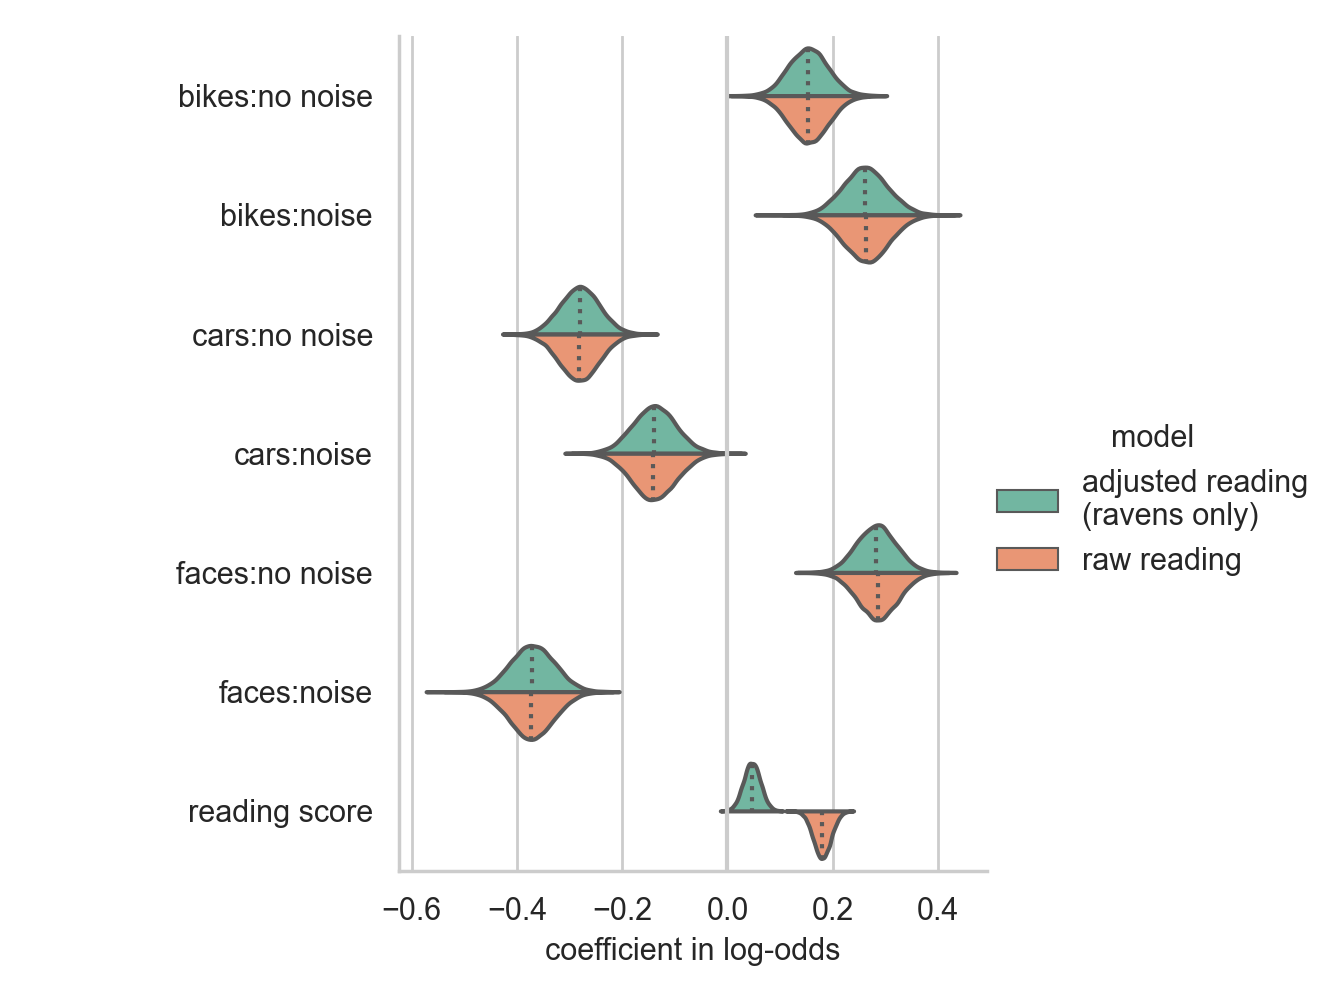

In [66]:
sns.set(style='whitegrid', palette='Set2', rc={'axes.labelsize': 11})
# create split-violin plot of posterior densities
trace = model1_adj.backend.trace
effects = pmu.conditional_effects(trace, simple_effects=['noise', 'faces', 'cars'], interactions=['adjusted_reading_score'])
renamed_effects = pmu.rename_vars(effects, varnames_dict={
    'Intercept': 'bikes:no noise',
    'noise': 'bikes:noise',
    'cars': 'cars:no noise',
    'faces': 'faces:no noise',
    'noise:cars': 'cars:noise',
    'noise:faces': 'faces:noise',
    'adjusted_reading_score': 'adjusted reading score',
})

trace_raw = model1.backend.trace
effects_raw = pmu.conditional_effects(trace_raw, simple_effects=['noise', 'faces', 'cars'], interactions=['raw_reading_score'])
renamed_effects_raw = pmu.rename_vars(effects_raw, varnames_dict={
    'Intercept': 'bikes:no noise',
    'noise': 'bikes:noise',
    'cars': 'cars:no noise',
    'faces': 'faces:no noise',
    'noise:cars': 'cars:noise',
    'noise:faces': 'faces:noise',
    'raw_reading_score': 'raw reading score',
})

df1 = pmu.trace_to_df(renamed_effects)
df1['model'] = 'adjusted reading\n(ravens only)'

df2 = pmu.trace_to_df(renamed_effects_raw)
df2['model'] = 'raw reading'

df_traces = pd.concat([df1, df2])
df_traces['variable'] = df_traces['variable'].str.replace('adjusted reading score', 'reading score').replace('raw reading score', 'reading score')

rcParams.update({'figure.autolayout': False})
g = sns.catplot(kind='violin', data=df_traces,
                y='variable', x='value', hue='model',
                split=True, cut=0, inner='quartile', order=sorted(df_traces['variable'].unique()))
g.set(xlabel='coefficient in log-odds', ylabel='')
g._legend.set_title('model', prop={'size': 11})
for l in g.ax.lines[0::3]:
    l.set_alpha(0)
for l in g.ax.lines[1::3]:
    l.set_linestyle(':')
for l in g.ax.lines[2::3]:
    l.set_alpha(0)
g.axes[0][0].axvline(0, color='.8', linestyle='-')
plt.savefig('figures/split_violins_ravens.pdf')
plt.savefig('figures/split_violins_ravens.png', dpi=600, bbox_inches='tight')

In [23]:
display(pm.summary(renamed_effects, credible_interval=.95).round(2))

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bikes:no noise,0.15,0.04,0.08,0.23,0.0,0.0,7429.0,7429.0,7427.0,10786.0,1.0
bikes:noise,0.26,0.04,0.18,0.34,0.0,0.0,14372.0,14287.0,14381.0,14883.0,1.0
cars:no noise,-0.28,0.04,-0.36,-0.21,0.0,0.0,21310.0,21300.0,21323.0,16953.0,1.0
faces:no noise,0.28,0.04,0.21,0.36,0.0,0.0,20114.0,20114.0,20121.0,16815.0,1.0
cars:noise,-0.14,0.04,-0.22,-0.06,0.0,0.0,22894.0,22783.0,22904.0,18516.0,1.0
faces:noise,-0.37,0.04,-0.45,-0.29,0.0,0.0,22772.0,22772.0,22766.0,18769.0,1.0
adjusted reading score,0.11,0.02,0.08,0.14,0.0,0.0,16110.0,16110.0,16099.0,13771.0,1.0


The effect of adjusted reading score is now .11 log-odds per standard deviation difference in adjusted reading score. It seems that adjusting reading score for only Raven's Progressive Matrices score (rather than for both Raven's and digit span) diminishes the efficacy of the adjustment procedure a little bit, but the change in the coefficient is so small that it **does not change the direction of the effect, or our conclusions.**

## Final note
In general, it is worth noting that our correction procedure was very conservative, and the parameter estimates for adjusted reading score likely represent a _lower bound_ for the true effect of learning to read. The true effect probably lies somewhere between that of adjusted and unadjusted reading score (i.e. **a positive effect, rather than the negative effect predicted by the destructive competition account** of neuronal recycling).